In [1]:
from sklearn.neighbors import NearestCentroid
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import random
random.seed(44)
np.random.seed(44)

import sys
sys.path.append('../')
from metrics import competition_scoring, default_competition_metric

In [2]:
X_train = np.load("../../data/x_train.npy")
y_train = np.load("../../data/y_train.npy")

X_val = np.load("../../data/x_val.npy")
y_val = np.load("../../data/y_val.npy")

## Nearest Centroids
As mentioned during the lecture, the shrunken nearest centroids algorithm is a powerful method of feature selection for linear methods

In [3]:
model = NearestCentroid(metric='euclidean', shrink_threshold=None)

In [4]:
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.478

Text(0.5, 1.0, 'Values of the centroids for each feature, class 1')

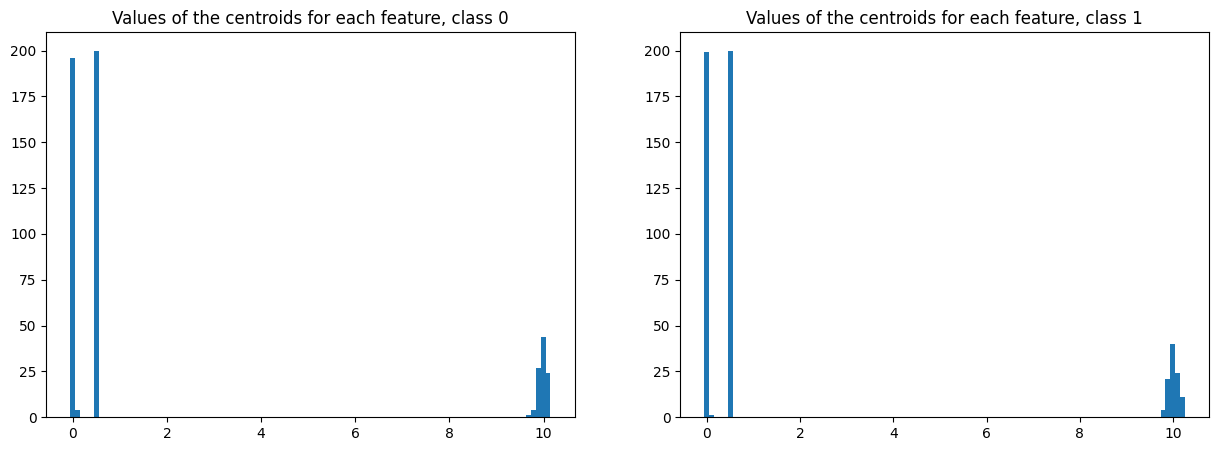

In [5]:
centroids = model.centroids_

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(centroids[0], bins = 100)
ax[0].set_title("Values of the centroids for each feature, class 0")

ax[1].hist(centroids[1], bins = 100)
ax[1].set_title("Values of the centroids for each feature, class 1")

looking at the plot, it seems that the most important features have centroid value near 10

In [6]:
model = NearestCentroid(metric='euclidean', shrink_threshold=10)

model.fit(X_train, y_train)
model.score(X_val, y_val)

0.501

Text(0.5, 1.0, 'Values of the centroids for each feature, class 1')

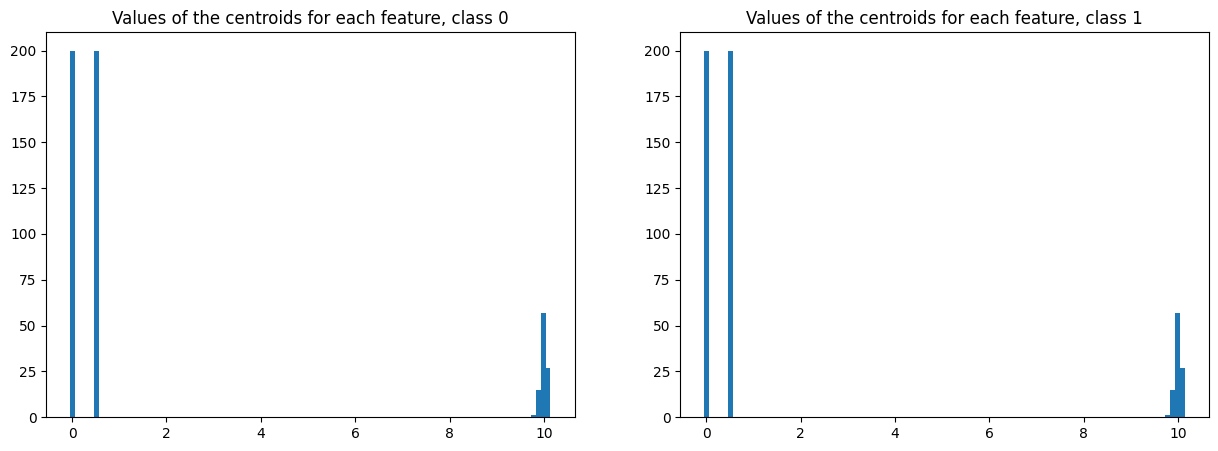

In [7]:
centroids = model.centroids_

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(centroids[0], bins = 100)
ax[0].set_title("Values of the centroids for each feature, class 0")

ax[1].hist(centroids[1], bins = 100)
ax[1].set_title("Values of the centroids for each feature, class 1")

In [8]:
treshold = 9
centroids = model.centroids_.sum(axis=0)
important_features = np.where(np.abs(centroids) > treshold)[0]

In [9]:
len(important_features)

100

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=44)
rf.fit(X_train[:, important_features], y_train)
y_pred = rf.predict(X_val[:, important_features])
print(f"Accuracy: {np.mean(y_pred == y_val)}")

Accuracy: 0.501


there might be some mistake in the approach above

## Method from Elements of Statistical Learning

Code below is based on repository https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks and https://www.pnas.org/doi/pdf/10.1073/pnas.082099299 implementation

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score

%matplotlib inline

# define commonly used colors
GRAY1, GRAY4, GRAY8, PURPLE = '#231F20', '#646369', '#A6A6A5', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

In [8]:
stratified_kfolds = StratifiedKFold(8, shuffle=True, random_state=1)
nearest_centroid_classifier = Pipeline([
    ('scale', StandardScaler()),
    ('ncc', NearestCentroid())]
)
# use grid search to select best shrink_threshold
shrink_threshold_grid_search = GridSearchCV(
    nearest_centroid_classifier,
    {'ncc__shrink_threshold': np.linspace(0.01, 100, 100)},
    cv=stratified_kfolds
).fit(X_train, y_train)
best_model = shrink_threshold_grid_search.best_estimator_
print('Test accuracy score',
      accuracy_score(y_val, best_model.predict(X_val)))

Test accuracy score 0.489


thats pretty poor results tho

In [9]:
class ShrunkenCentroid(BaseEstimator, ClassifierMixin):
    """Nearest shrunken centroid classifier.
    Each class is represented by its centroid, with test samples classified to
    the class with the nearest centroid.
    Parameters
    ----------
    delta : float, optional (default = None)
        Delta for shrinking centroids to remove features.
    ----------
    classes_:
        All classes found in the training data set.
    centroids_ :
        Centroid of each class.
    overall_centroid_:
        The overall mean of each feature.
    priors_:
        Class prior probabilities.
    vars_:
        Pooled within-class variances of features.
    shrunken_centroids_:
        Shrunken centroid of each class.
    features_used_:
        The indices of features that are not shrunken to the overall centroid.
    """
    def __init__(self, delta: float = 0):
        self.delta = delta

    def fit(self, X: np.ndarray, y: np.array) -> 'ShrunkenCentroid':
        """
        Fit the ShrunkenCentroid model according to the given training data.
        Parameters
        ----------
        X :
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.
        y :
            Target values (integers)
        """
        # relabel target values to start from zero
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        self.classes_ = label_encoder.classes_
        N, p, K = *X.shape, self.classes_.size
        # calculated overall centroid and prior probabilities
        self.overall_centroid_ = np.mean(X, axis=0)
        _, counts = np.unique(y, return_counts=True)
        self.priors_ = counts / N
        # calculate correction coefficients for each class
        m = np.atleast_2d((1/counts - 1/N)**0.5).T
        self.centroids_ =\
            np.vstack([np.mean(X[y == k, :], axis=0) for k in range(K)])
        # pooled within-class variance and deviation of features
        self.vars_ = np.zeros(shape=p)
        for k in range(K):
            self.vars_ += np.sum((X[y == k, :]-self.centroids_[k])**2, axis=0)
        self.vars_ /= (N - K)
        stds = self.vars_ ** 0.5
        # calculate shrunken centroids
        distances = self.centroids_ - self.overall_centroid_
        mean_std = np.median(stds)
        t_stats = distances / (stds + mean_std) / m
        t_stats_shrunken =\
            np.sign(t_stats) * (np.abs(t_stats) - self.delta).clip(0)
        self.shrunken_centroids_ =\
            self.overall_centroid_ + m * (stds + mean_std) * t_stats_shrunken
        self.features_used_ = np.squeeze(np.argwhere(np.sum(np.abs(
            self.shrunken_centroids_ - self.overall_centroid_), axis=0) > 0))
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Perform classification on an array of test vectors X.
        The predicted class C for each sample in X is returned.
        Parameters
        ----------
        X : array, shape = [n_samples, n_features]
        Returns
        -------
        C : array, shape = [n_samples]
        """
        N, K = X.shape[0], self.classes_.size
        discriminators = np.zeros(shape=(N, K))
        for i in range(N):
            discriminators[i] = -np.sum(
                (self.shrunken_centroids_ - X[i])**2 / self.vars_, axis=1) +\
                                2*np.log(self.priors_)
        return self.classes_[np.argmax(discriminators, axis=1)]

In [66]:
# PAGE 655. FIGURE 18.4 (Top): Error curves for the SRBCT data. Shown are the
#           training, 10-fold cross-validation, and test misclassification
#           errors as the threshold parameter Δ is varied. The value Δ = 4.34
#           is chosed by CV, resulting in a subset of 43 seleted genes.
# calculate
deltas = np.linspace(0, 3, 14*4 + 1)
n_features, err_cv, err_train, err_test = [], [], [], []
for delta in deltas:
    sc = ShrunkenCentroid(delta=delta).fit(X_train, y_train)
    cv_accuracy = np.mean(cross_val_score(
        ShrunkenCentroid(delta=delta), X_train, y_train, cv=8))
    err_cv.append(1 - cv_accuracy)
    err_train.append(1 - sc.score(X_train, y_train))
    err_test.append(1 - sc.score(X_val, y_val))
    n_features.append(sc.features_used_.size)


In [42]:
deltas

array([0.        , 0.05357143, 0.10714286, 0.16071429, 0.21428571,
       0.26785714, 0.32142857, 0.375     , 0.42857143, 0.48214286,
       0.53571429, 0.58928571, 0.64285714, 0.69642857, 0.75      ,
       0.80357143, 0.85714286, 0.91071429, 0.96428571, 1.01785714,
       1.07142857, 1.125     , 1.17857143, 1.23214286, 1.28571429,
       1.33928571, 1.39285714, 1.44642857, 1.5       , 1.55357143,
       1.60714286, 1.66071429, 1.71428571, 1.76785714, 1.82142857,
       1.875     , 1.92857143, 1.98214286, 2.03571429, 2.08928571,
       2.14285714, 2.19642857, 2.25      , 2.30357143, 2.35714286,
       2.41071429, 2.46428571, 2.51785714, 2.57142857, 2.625     ,
       2.67857143, 2.73214286, 2.78571429, 2.83928571, 2.89285714,
       2.94642857, 3.        ])

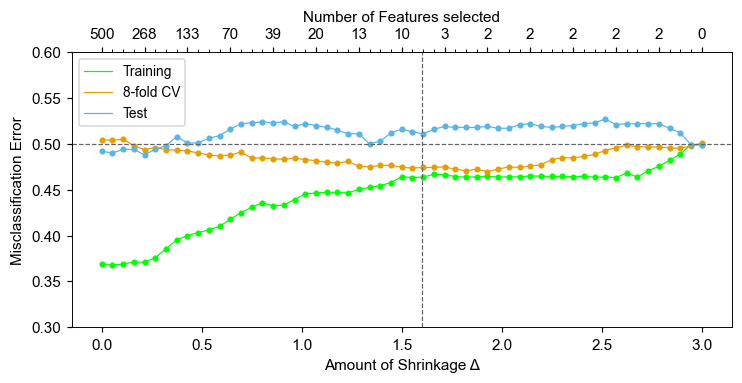

In [70]:

fig, ax = plt.subplots(figsize=(6, 2.5), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(deltas, err_train, c='#00FF00', s=9)
ax.plot(deltas, err_train, c='#00FF00', linewidth=0.8, label='Training')
ax.scatter(deltas, err_cv, c=ORANGE, s=9)
ax.plot(deltas, err_cv, c=ORANGE, linewidth=0.8, label='8-fold CV')
ax.plot(deltas, err_test, c=BLUE, linewidth=0.8, label='Test')
ax.scatter(deltas, err_test, c=BLUE, s=9)
ax.set_ylim(0.3, 0.6)
ax.axhline(y=0.5, c=GRAY4, linewidth=0.8, linestyle='--')
ax.axvline(x=1.6, c=GRAY4, linewidth=0.8, linestyle='--')
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(deltas[::4])
ax2.set_xticks(deltas, minor=True)
ax2.set_xticklabels(n_features[::4])
ax.set_xlabel('Amount of Shrinkage Δ')
ax.set_ylabel('Misclassification Error')
ax2.set_xlabel('Number of Features selected')
_ = ax.legend(loc='upper left', prop={'size': 9})

In [45]:
# now train some rf
from sklearn.ensemble import RandomForestClassifier
cv_scores = []
train_scores = []
test_scores = []

for features in n_features[:-1]:
    rf = RandomForestClassifier(random_state=44)
    # crossvalidation
    cv_score = np.mean(cross_val_score(rf, X_train[:, :features], y_train, cv=8, scoring=competition_scoring))
    # training score
    rf.fit(X_train[:, :features], y_train)
    train_score = competition_scoring(rf, X_train[:, :features], y_train)
    test_score = competition_scoring(rf, X_val[:, :features], y_val)
    
    cv_scores.append(cv_score)
    train_scores.append(train_score)   
    test_scores.append(test_score)

In [48]:
n_features = n_features[:-1]
deltas = deltas[:-1]

In [ ]:
train_scores.append(5000)
cv_scores.append(5000)

In [46]:
len(cv_scores)

56

In [49]:
len(deltas)

56

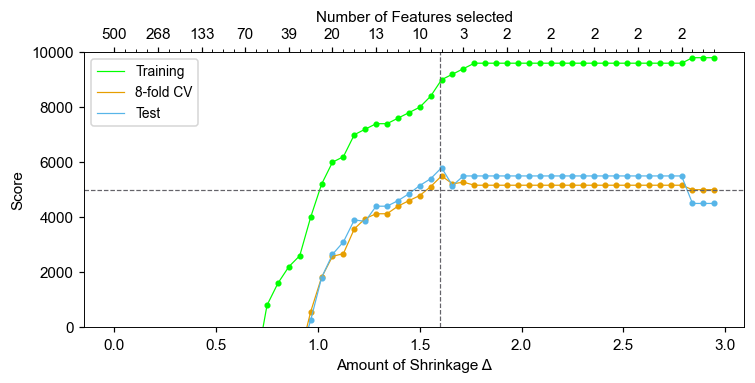

In [64]:

fig, ax = plt.subplots(figsize=(6, 2.5), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(deltas, train_scores, c='#00FF00', s=9)
ax.plot(deltas, train_scores, c='#00FF00', linewidth=0.8, label='Training')
ax.scatter(deltas, cv_scores, c=ORANGE, s=9)
ax.plot(deltas, cv_scores, c=ORANGE, linewidth=0.8, label='8-fold CV')

ax.plot(deltas, test_scores, c=BLUE, linewidth=0.8, label='Test')
ax.scatter(deltas, test_scores, c=BLUE, s=9)

ax.set_ylim(0, 10000)
ax.axhline(y=5000, c=GRAY4, linewidth=0.8, linestyle='--')
ax.axvline(x=1.6, c=GRAY4, linewidth=0.8, linestyle='--')
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(deltas[::4])
ax2.set_xticks(deltas, minor=True)
ax2.set_xticklabels(n_features[::4])
ax.set_xlabel('Amount of Shrinkage Δ')
ax.set_ylabel('Score')
ax2.set_xlabel('Number of Features selected')
_ = ax.legend(loc='upper left', prop={'size': 9})

lets set delta to 1.6

In [81]:

shrunken_centroid_classifier = ShrunkenCentroid(
    delta=2.9).fit(X_train, y_train)
print(f'Number of genes used {shrunken_centroid_classifier.features_used_.size}')

Number of genes used 1


In [82]:
shrunken_centroid_classifier.features_used_

array(466, dtype=int64)

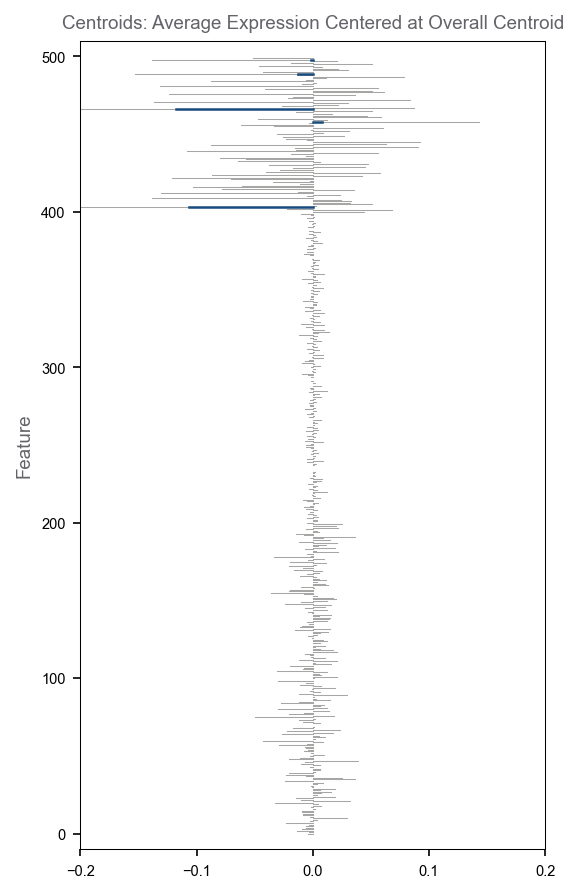

In [56]:
# PAGE 655. FIGURE 18.4 (Bottom): Four centroids profiles d_kj, for the SRBCT
#           data (gray), relative to the overall centroid. Each centroid has
#           2308 components, and we see considerable noise. The blue bars are
#           shrunken versions d'_kj of these centroids, obtained by
#           soft-thresholding the gray bars, using Δ = 4.3.
def plot_means(ax, model, class_index, title, hide_y_labels=True):
    means = model.centroids_[class_index] - model.overall_centroid_
    d_shrunken = model.shrunken_centroids_[class_index] - \
        model.overall_centroid_
    for i in range(means.shape[0]):
        ax.plot([0, means[i]], [i, i], linewidth=0.5, color=GRAY8)
    for i in range(d_shrunken.shape[0]):
        if d_shrunken[i] == 0:
            continue
        ax.plot([0, d_shrunken[i]], [i, i], linewidth=1.2, color='#174A7E')
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-10, 510)
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(7)
    if hide_y_labels:
        ax.tick_params(labelleft=False, left=False)
    else:
        ax.set_ylabel('Feature', color=GRAY4, fontsize=9)
    ax.text(0, 0, title, color=GRAY4, fontsize=8,
        horizontalalignment='center')

fig, axarr = plt.subplots(
    1, 1, sharex=True, sharey=True, figsize=(4, 7), dpi=150)
plot_means(axarr, shrunken_centroid_classifier, 0, '', False)
axarr.set_title(
    'Centroids: Average Expression Centered at Overall Centroid',
    color=GRAY4, fontsize=9, horizontalalignment='center')
plt.show()

In [57]:
# the selected features
selected_genes = shrunken_centroid_classifier.features_used_
selected_genes

array([403, 458, 466, 489, 498], dtype=int64)

In [58]:
np.save("nsc.npy", selected_genes)

### random forest based on the features above

In [59]:
X_train_selected = X_train[:, selected_genes]
X_val_selected = X_val[:, selected_genes]


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=44)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_val_selected)
print(f"Accuracy: {np.mean(y_pred == y_val)}")

Accuracy: 0.506


In [61]:
y_proba = rf.predict_proba(X_val_selected)[:, 1]
default_competition_metric(y_val, y_pred_proba=y_proba, k = 5) 

3400.0

In [62]:
# add interactions
from sklearn.preprocessing import PolynomialFeatures

X_train_interactions = PolynomialFeatures(degree=3).fit_transform(X_train_selected)

In [63]:
rf.fit(X_train_interactions, y_train)

X_val_interactions = PolynomialFeatures(degree = 3).fit_transform(X_val_selected)

y_pred = rf.predict(X_val_interactions)
print(f"Accuracy: {np.mean(y_pred == y_val)}")

default_competition_metric(y_val, y_pred_proba=y_proba, k = 10)

Accuracy: 0.506


2400.0